In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
# Data Preprocessing
train_transforms = transforms.Compose([
    transforms.Resize((128,128)),      # Resize all images
    transforms.RandomHorizontalFlip(), # Data augmentation
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])  # Normalization
])

test_transforms = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

train_dir = r"C:\Users\okeiy\Downloads\Brain_Tumor\Training"
test_dir  = r"C:\Users\okeiy\Downloads\Brain_Tumor\Testing"

train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
test_data  = datasets.ImageFolder(test_dir, transform=test_transforms)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=32, shuffle=False)

print("Classes:", train_data.classes)

Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [4]:
# Define CNN Model
class BrainTumorCNN(nn.Module):
    def __init__(self):
        super(BrainTumorCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1), # (128x128x32)
            nn.ReLU(),
            nn.MaxPool2d(2,2),                                   # (64x64x32)

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # (64x64x64)
            nn.ReLU(),
            nn.MaxPool2d(2,2),                                     # (32x32x64)

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # (32x32x128)
            nn.ReLU(),
            nn.MaxPool2d(2,2)                                       # (16x16x128)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16*16*128, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 4)   # 4 classes
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

model = BrainTumorCNN().to(device)
print(model)

BrainTumorCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32768, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=4, bias=True)
  )
)


In [5]:
# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
# Training Loop with tqdm
epochs = 15
train_losses, valid_losses = [], []

for epoch in range(epochs):
    # Training
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}]", leave=False)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # update tqdm description dynamically
        loop.set_postfix(loss=loss.item(), acc=100*correct/total)

    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = 100 * val_correct / val_total
    val_loss = val_loss / len(test_loader)

    train_losses.append(train_loss)
    valid_losses.append(val_loss)

    # summary after each epoch
    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

Epoch [1/15] Train Loss: 0.7063, Train Acc: 71.88% | Val Loss: 0.5981, Val Acc: 77.65%


Epoch [2/15] Train Loss: 0.4285, Train Acc: 83.68% | Val Loss: 0.4177, Val Acc: 83.98%


Epoch [3/15] Train Loss: 0.3259, Train Acc: 87.69% | Val Loss: 0.3421, Val Acc: 85.66%


Epoch [4/15] Train Loss: 0.2604, Train Acc: 89.97% | Val Loss: 0.2479, Val Acc: 90.92%


Epoch [5/15] Train Loss: 0.2169, Train Acc: 91.95% | Val Loss: 0.2973, Val Acc: 88.02%


Epoch [6/15] Train Loss: 0.1747, Train Acc: 93.73% | Val Loss: 0.1750, Val Acc: 93.97%


Epoch [7/15] Train Loss: 0.1437, Train Acc: 94.68% | Val Loss: 0.1373, Val Acc: 94.81%


Epoch [8/15] Train Loss: 0.1173, Train Acc: 95.69% | Val Loss: 0.1282, Val Acc: 95.80%


Epoch [9/15] Train Loss: 0.0991, Train Acc: 96.36% | Val Loss: 0.1089, Val Acc: 96.34%


Epoch [10/15] Train Loss: 0.0801, Train Acc: 97.53% | Val Loss: 0.0765, Val Acc: 97.94%


Epoch [11/15] Train Loss: 0.0644, Train Acc: 97.72% | Val Loss: 0.0711, Val Acc: 97.86%


Epoch [12/15] Train Loss: 0.0650, Train Acc: 97.69% | Val Loss: 0.0794, Val Acc: 97.86%


Epoch [13/15] Train Loss: 0.0598, Train Acc: 97.90% | Val Loss: 0.0738, Val Acc: 98.02%


Epoch [14/15] Train Loss: 0.0510, Train Acc: 98.41% | Val Loss: 0.0753, Val Acc: 98.02%


Epoch [15/15] Train Loss: 0.0386, Train Acc: 98.63% | Val Loss: 0.0465, Val Acc: 98.78%


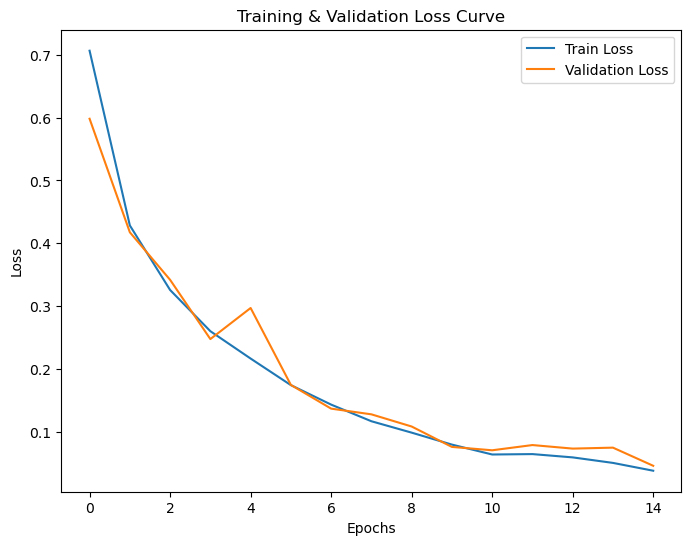

In [7]:
# Plot Loss Curves
plt.figure(figsize=(8,6))
plt.plot(train_losses, label="Train Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Curve")
plt.legend()

# Save figure
plt.savefig("loss_curve.png", dpi=300, bbox_inches='tight')

# Show figure
plt.show()

Classification Report:
               precision    recall  f1-score   support

      glioma       0.99      0.98      0.99       300
  meningioma       0.98      0.97      0.97       306
     notumor       0.99      1.00      0.99       405
   pituitary       0.99      1.00      1.00       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



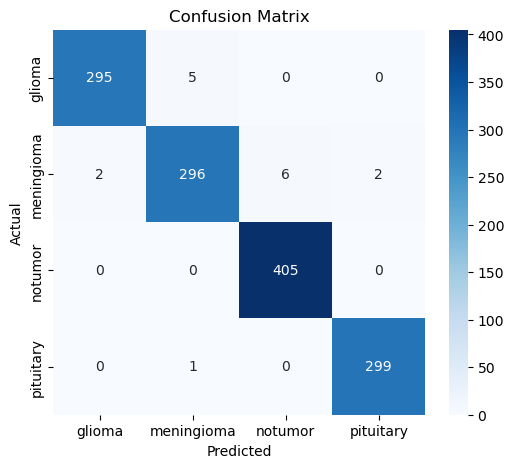

In [8]:
# Evaluation on Test Data
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification Report
report = classification_report(all_labels, all_preds, target_names=train_data.classes)
print("Classification Report:\n", report)

# Save report
with open("classification_report.txt", "w") as f:
    f.write(report)

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=train_data.classes,
            yticklabels=train_data.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

# Save CM
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

In [9]:
#  Save Model
torch.save(model.state_dict(), "brain_tumor_cnn.pth")
print("Model saved as brain_tumor_cnn.pth")

Model saved as brain_tumor_cnn.pth


In [10]:
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F

def predict_and_show_topk(image_path, model, transform, class_names, topk=3):
    """
    Predict the top-k classes of a single image and display it with predictions.
    
    Args:
        image_path (str): path to the image
        model (torch.nn.Module): trained model
        transform (torchvision.transforms): same preprocessing as training
        class_names (list): list of class labels
        topk (int): number of top predictions to return
    """
    # Load image
    image = Image.open(image_path).convert("RGB")
    
    # Apply transforms and add batch dimension
    img_tensor = transform(image).unsqueeze(0).to(device)

    # Run prediction
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        probs = F.softmax(outputs, dim=1)  # logits -> probabilities
        top_probs, top_indices = probs.topk(topk, dim=1)
    
    # Convert to numpy
    top_probs = top_probs.cpu().numpy().flatten()
    top_indices = top_indices.cpu().numpy().flatten()
    top_classes = [class_names[i] for i in top_indices]
    
    # Plot image with Top-1 prediction
    plt.imshow(image)
    plt.title(f"Top-1 Prediction: {top_classes[0]} ({top_probs[0]*100:.2f}%)")
    plt.axis("off")
    plt.show()
    
    # Print top-k predictions
    print("Top Predictions:")
    for cls, prob in zip(top_classes, top_probs):
        print(f"{cls}: {prob*100:.2f}%")
    
    return list(zip(top_classes, top_probs))

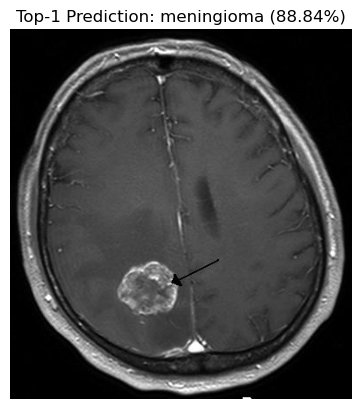

Top Predictions:
meningioma: 88.84%
notumor: 11.03%
pituitary: 0.13%


In [19]:
# Reload model 
model = BrainTumorCNN().to(device)
model.load_state_dict(torch.load("brain_tumor_cnn.pth", map_location=device))
model.eval()

# Example MRI image path (change this to your own test image)
image_path = r"C:\Users\okeiy\Pictures\222.jpg"

# Run prediction
predictions = predict_and_show_topk(image_path, model, test_transforms, train_data.classes, topk=3)